# Exploring MS verticies

In [104]:
#Import libraries
import uproot
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
import time

In [105]:
#Load signal file
sig_file = uproot.open("user.calpert.mc16_13TeV.311423.MGPy8EG_A14NNPDF23_NNPDF31ME_HSS_LLP_mH600_mS150_lthigh.032123_trees.root/user.calpert.311423.e7357_e5984_s3234_r10201_r10210_p4696.32829947._000001.trees.root:trees_DV_")

### Begin with a preselection

In [103]:
#Begin with preselection cuts: trigger, has good PV and multiplicity > 2

Text(0.5, 1.0, 'Histogram of Trigger and Good PV (Signal)')

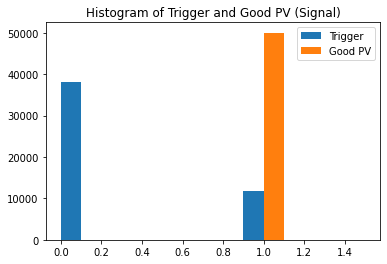

In [110]:
#Make plots of trigger and goodPV preselection cuts to see what we're working with
plt.hist(sig_file["pass_HLT_j30_muvtx_noiso"].array(), label = "Trigger")
plt.hist(sig_file["hasGoodPV"].array(), label = "Good PV")
plt.legend()
plt.title("Histogram of Trigger and Good PV (Signal)")

In [111]:
#Make plot of multiplicity candidates
#To check for MS vertex multiplicity >2, we simply need to count the number of events that produce >1 vertex. This can
#be done by counting any of the branches with a prefix of MSVtx_xxx. Let's use MSVtx_eta.

In [138]:
mvtx_count = sig_file["MSVtx_eta"].array()

In [139]:
#Number of events with more than one vertex
num_vtx=len(mvtx_count[ak.num(mvtx_count)>1])
print(num_vtx)

1014


Text(0.5, 1.0, 'Multiplicity of verticies')

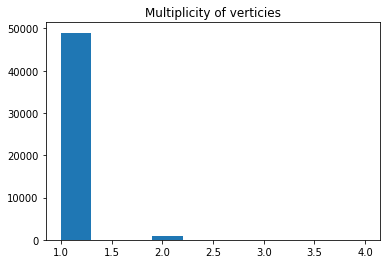

In [112]:
plt.hist(ak.num(mvtx_count))
plt.title("Multiplicity of verticies")

In [113]:
#Only a small percentage of events have >1 vertex. Given this, we should expect only a small fraction of events to pass our preselection

In [135]:
print(f'Percentage of events with more than one vertex is {(num_vtx/(len(mvtx_count))*100):.2f}%')

Percentage of events with more than one vertex is 2.03%


In [140]:
#Now create boolean arrays for all of our preselection events and filter events that pass all three preselections

In [115]:
trig = sig_file["pass_HLT_j30_muvtx_noiso"].array()#(entry_stop = 10)
goodPV = sig_file["hasGoodPV"].array()#(entry_stop = 10)
mult_cut = ak.num(mvtx_count)>1

In [270]:
mult_cut

<Array [False, False, False, ... False, False] type='50000 * bool'>

#### Preselection Cut

In [118]:
# THIS IS OUR PRESELECTION CUT
pre_cut = (trig == True) & (goodPV == True) & (mult_cut == True)

In [141]:
#Check that pre_cut has non-null values
ak.any(pre_cut)

True

In [142]:
#List percentage of events that pass the cut
print(f'Precentage of events that pass preselection is {(ak.count_nonzero(pre_cut)/ak.count(pre_cut))*100:.2f}%')

Precentage of events that pass preselection is 1.34%


In [143]:
#Only 1.34% of events pass preselection. Let move onto our event selection

# Event Selection

In [29]:
#First , lets take a look at MDT/RPC/TGC hits

### MDT/TGC/RPC Hits

In [30]:
#Flatten arrays
MDT_flat =ak.flatten(sig_file["MSVtx_nMDT"].array())
RPC_flat = ak.flatten(sig_file["MSVtx_nRPC"].array())
TGC_flat = ak.flatten(sig_file["MSVtx_nTGC"].array())

<Figure size 432x288 with 0 Axes>

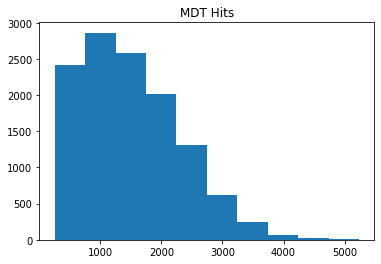

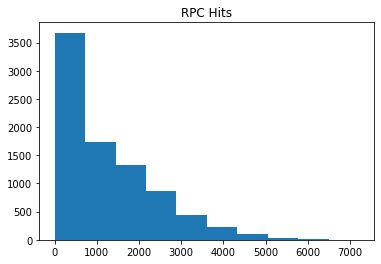

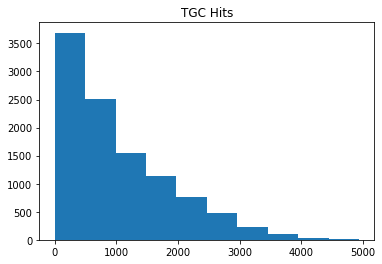

<Figure size 432x288 with 0 Axes>

In [31]:
#Plot a histogram of hits from all three sources. Include only nonnegative values
plt.hist(MDT_flat[MDT_flat>0], label = "MDT hits")
plt.title("MDT Hits")
plt.figure()
plt.hist(RPC_flat[RPC_flat>0], label = "RPC hits")
plt.title("RPC Hits")
plt.figure()
plt.hist(TGC_flat[TGC_flat>0], label = "TGC hits")
plt.title("TGC Hits")
plt.figure()

In [ ]:
#Good Vertex Candidates begin with the # of hits in different sectors of MS.
#Two sepearte cutflows will need to be calculated for both the barrel and endcaps

In [243]:
mdt = sig_file["MSVtx_nMDT"].array()#(entry_stop = 10)

In [244]:
rpc = sig_file["MSVtx_nRPC"].array()#(entry_stop = 10)

In [245]:
tgc = sig_file["MSVtx_nTGC"].array()#(entry_stop = 10)

In [246]:
eta = sig_file["MSVtx_eta"].array()#(entry_stop = 10)

In [247]:
phi = sig_file["MSVtx_phi"].array()#(entry_stop = 10)

In [248]:
#We will need to perform separate calcuations for barrel and endcap

#### Barrel and Endcap cuts for MDT/TGC/RPC hits

In [249]:
#CUT FOR MDT AND RPC HITS IN BARREL
hits_barrel_cut= ((mdt > 300) & (mdt < 3000))\
& ((rpc > 250) & (abs(eta) < 1.0))

In [250]:
#CUT FOR MDT AND TGC HITS IN THE ENDCAP
hits_endcap_cut= ((mdt > 300) & (mdt < 3000))\
& ((tgc > 250) & ((abs(eta) > 1.0) & (abs(eta) < 2.5)))

In [52]:
#Check that both cuts filtered out good candidates

In [53]:
ak.any(barrelCut)

True

In [54]:
ak.any(endCut)

True

In [55]:
#Check percentage of cuts that passed

In [58]:
ak.count_nonzero(barrelCut)/ak.count(barrelCut)*100

7.698333431251592

In [59]:
ak.count_nonzero(endCut)/ak.count(endCut)*100

13.555803615142079

### Track Isolation

In [60]:
#Now we need to isolate the tracks that are > 5 GeV. 
#In the barrel this requires a cone Delta(R) > 0.3
#In the endcap this requires a cone Delta(R) > 0.6

In [6]:
track_eta = sig_file["track_eta"].array()

In [7]:
track_phi = sig_file["track_phi"].array()

In [10]:
track_pT = sig_file["track_pT"].array()

In [134]:
#Count all combinations of abs(delta(eta)) and discard duplicates

In [142]:
st = time.time()
DeltaEta = []
for array in track_eta:
    delta_eta= []
    for i, value in enumerate(array):
        for j, number in enumerate(array):
            if (i+j) >= (len(array)-1):
                break
            delta_eta.append(abs(array[i]-array[i+j+1]))
            DeltaEta.append(delta_eta)
end = time.time()
print(end - st)

87.98134922981262


In [ ]:
#Count all combinations of abs(delta(eta)) and discard duplicates

In [111]:
st = time.time()
DeltaPhi = []
for array in track_phi:
    delta_phi= []
    for i, value in enumerate(array):
        for j, number in enumerate(array):
            if (i+j) >= (len(array)-1):
                break
            delta_phi.append(abs(array[i]-array[i+j+1]))
            DeltaPhi.append(delta_phi)
end = time.time()
print(end - st)

In [5]:
### THESE COMPUTATIONS ARE TOO EXPENSIVE!!!. Let's try with ak.combinations instead

In [8]:
eta_pairs = ak.combinations(track_eta, n=2, fields = ["x","y"])
delta_eta=abs(eta_pairs["y"] - eta_pairs["x"])

In [9]:
phi_pairs = ak.combinations(track_phi, n=2, fields = ["x","y"])
delta_phi=abs(phi_pairs["y"] - phi_pairs["x"])

Text(0.5, 1.0, 'Delta Eta')

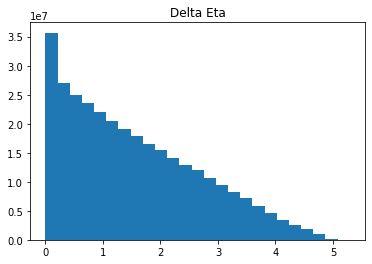

In [53]:
plt.hist(ak.flatten(delta_eta), bins=25)
plt.title("Delta Eta")

Text(0.5, 1.0, 'Delta Phi')

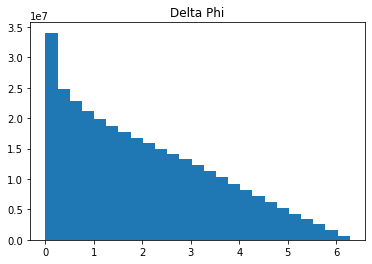

In [52]:
plt.hist(ak.flatten(delta_phi), bins=25)
plt.title("Delta Phi")

In [55]:
delta_phi_sq = delta_phi * delta_phi

In [56]:
delta_eta_sq = delta_eta * delta_eta

In [57]:
#Calculate Delta(R)^2

In [59]:
delta_R_sq = delta_phi_sq + delta_eta_sq

In [69]:
#For Barrel, we need track isolation with a Delta(R)^2 > 0.09...(from delta(R) > 0.3)
#For Endcaps, we need track isolation with a Delta(R)^2 > 0.036...(from delta(R) > 0.6)

#### Barrel and Endcap Cuts for track isolation

In [60]:
#CUT FOR TRACK ISOLATION IN THE BARREL
track_iso_barrel = delta_R_sq > 0.09

In [61]:
#CUT FOR TRACK ISOLATION IN THE ENDCAP
track_iso_endcap = delta_R_sq > 0.036

In [62]:
#Check that good candidates remain

In [64]:
ak.any(track_iso_barrel)

True

In [65]:
ak.any(track_iso_endcap)

True

In [74]:
#Look at a histogram of delta_R_sq

Text(0.5, 1.0, 'Histogram of Delta(R) squared')

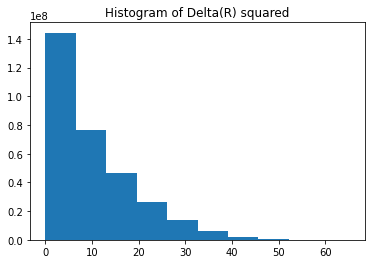

In [76]:
plt.hist(ak.flatten(delta_R_sq))
plt.title("Histogram of Delta(R) squared")

In [ ]:
#Judging from the histogram it appears that our cuts will remove only a small percentage of hits

In [98]:
percent_track_barrel = ak.count_nonzero(track_iso_barrel)/ak.count(track_iso_barrel)*100
print(f'Percent of barrel hits that pass track isolation filter is  {percent_track_barrel:.2f}%')

Percent of barrel hits that pass track isolation filter is  96.28%


In [100]:
percent_track_endcap = ak.count_nonzero(track_iso_endcap)/ak.count(track_iso_endcap)*100
print(f'Percent of endcap hits that pass track isolation filter is  {percent_track_endcap:.2f}%')

Percent of endcap hits that pass track isolation filter is  97.71%


In [101]:
#Indeed we are left with a majority of hits after applying the track isolation filter

### Jet Isolation

In [144]:
#Now perform >17GeV jet isolaton

In [163]:
jet_eta = sig_file["jet_eta"].array()

In [164]:
jet_phi = sig_file["jet_phi"].array()

In [165]:
jet_eta_pairs = ak.combinations(jet_eta, n=2, fields = ["x","y"])
jet_delta_eta=abs(jet_eta_pairs["y"] - jet_eta_pairs["x"])

In [166]:
jet_phi_pairs = ak.combinations(jet_phi, n=2, fields = ["x","y"])
jet_delta_phi=abs(jet_phi_pairs["y"] - jet_phi_pairs["x"])

In [169]:
jet_eta_sq = jet_delta_eta * jet_delta_eta

In [170]:
jet_phi_sq = jet_delta_phi * jet_delta_phi

In [171]:
jet_R_sq = jet_eta_sq + jet_phi_sq

In [172]:
#Plot Jet_R_sq

Text(0.5, 1.0, 'Plot of Jet Delta(R)^2')

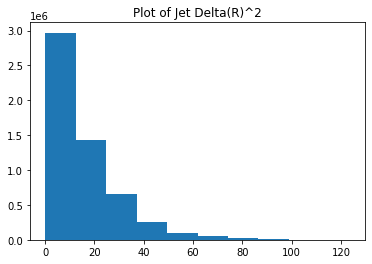

In [174]:
plt.hist(ak.flatten(jet_R_sq))
plt.title("Plot of Jet Delta(R)^2")

In [175]:
#Cut Delta(R)^2 at 0.09 for barrel
#Cut Delta(R)^2 at 0.036 for endcap

#### Jet Isolation Cut

In [201]:
#CUTS FOR JET ISOLATION > 17 GeV
jet_iso_barrel = jet_R_sq > 0.09
jet_iso_endcap = jet_R_sq > 0.036

In [178]:
#Again we expect a high percentage to remain

In [186]:
jet_iso_barrel_pct=ak.count_nonzero(jet_iso_barrel)/ak.count(jet_iso_barrel)*100
jet_iso_endcap_pct=ak.count_nonzero(jet_iso_endcap)/ak.count(jet_iso_endcap)*100

In [196]:
print(f'Percent of jet remaining in barrel is {jet_iso_barrel_pct:.2f}%')
print(f'Percent of jet remaining in endcap is {jet_iso_endcap_pct:.2f}%')

Percent of jet remaining in barrel is 100.00%
Percent of jet remaining in endcap is 100.00%


In [199]:
ak.min(jet_R_sq)

0.09133394902592333

In [200]:
#As we can see, the minimum of jet_R_sq is 0.09133... so all jets make the cut and are therefore > 17GeV

In [202]:
#We can finish are event selection with a filter on abs(sum(track pT)) in a 0.2 cone

### Sum track pT

In [330]:
sum_pT = sig_file['MSVtx_sumTrackPt0p2Cone'].array()  ###WARNING.....MAY BE INCORRECT BRANCH

(array([38927.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        11678.,   458.]),
 array([-99999.       , -88686.5703794, -77374.1407588, -66061.7111382,
        -54749.2815176, -43436.851897 , -32124.4222764, -20811.9926558,
         -9499.5630352,   1812.8665854,  13125.296206 ]),
 <BarContainer object of 10 artists>)

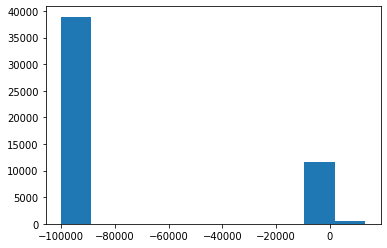

In [234]:
plt.hist(ak.flatten(sum_pT))

In [235]:
#We will need remove all extraneous values

#### Sum track pT Cut

In [236]:
#CUT FOR abs(sum(track pT))
sum_pT_cut = (sum_pT > -1e+05) & (abs(sum_pT) < 10 )

In [237]:
sum_pT_cut_pct = ak.count_nonzero(sum_pT_cut)/ak.count(sum_pT_cut)*100

In [238]:
#Percentage of track abs(sum(pT)) in both barrel and endcap
print(f'Percentage of track abs(sum(pT)) is {sum_pT_cut_pct:.2f}%')

Percentage of track abs(sum(pT)) is 19.73%


In [239]:
### NOTE: NEED TO CHECK IF THIS IS CORRECT BRANCH....COULD BE 'MSVtx_MSTracklet_VectSumpT' ###

In [240]:
#Now we can combine the all the cuts for the barrel and endcap to get an event selection boolean matrix

In [331]:
###Insert code here for event selection

In [256]:
#Now that we have our preselection, and our event selection, we can move onto to remaining MS Vertex selection criteria

### Min # Vertex Tracklets Cut, Veto region and Jet selection

In [257]:
#We require minimum vertex tracklets to be 3(4) in barrel(endcap) and a MS overlap region veto as well as a HCal crack veto.

In [266]:
#Min vertex tracklets first. We will import the 'MSVtx_MSTracklet_avgdR' branch to use as a count:
vtx_track=sig_file['MSVtx_MSTracklet_avgdR'].array()

In [267]:
#Number of events with three tracks and 4 tracks
vtx_track_three=len(vtx_track[ak.num(vtx_track)==3])
vtx_track_four=len(vtx_track[ak.num(vtx_track)==4])

#### Min # Vertex Tracklets Cut

In [333]:
#CUTS FOR MIN VERTEX TRACKLETS
vtx_track_cut_barrel = ak.num(vtx_track)==3
vtx_track_cut_endcap = ak.num(vtx_track)==4

In [273]:
#Now for the overlap region and crack veto. This can be done with one cut from 0.7 < abs(eta_vtx) < 1.3

#### Veto Region Cut

In [275]:
#CUT FOR VETO REGION
veto_cut = (0.7 < eta) & (1.3 > eta)

In [279]:
#Now all we need is the jet selection cuts: pT > 30 GeV, log Ehad/Eem < 0.5 and JVT > 0.59 if jet pT < 60 GeV

In [285]:
jet_pT=sig_file['jet_pT'].array()
Ehad_Eem=sig_file['jet_logRatio'].array()
jet_JVT=sig_file['jet_jvt'].array()

#### Jet Selection Cuts

In [286]:
jet_cut = (jet_pT > 30) & (Ehad_Eem < 0.5) & ((jet_JVT > 0.59) & (jet_pT < 60))

In [288]:
ak.count_nonzero(jet_cut)/ak.count(jet_cut)

0.03547387510888346